# Chapter 4. Training Models

Define the default font sizes to make the figures prettier:

In [10]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

generate some linear-looking data to test the normal equation:

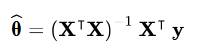

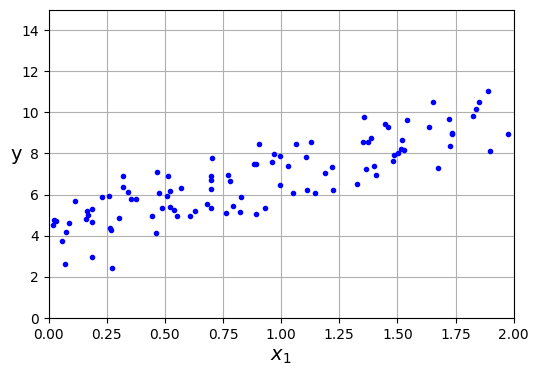

In [16]:
import numpy as np

np.random.seed(42) # to make this code reproducible
m = 100 # number of instances
X = 2 * np.random.default_rng().random(size=(m, 1)) # column vector
y = 4 + 3 * X + np.random.default_rng().standard_normal(size=(m, 1))

plt.figure(figsize=(6,4))
plt.plot(X, y, "b.")
plt.ylabel("y", rotation=0)
plt.xlabel("$x_1$")
plt.grid()
plt.axis([0, 2, 0, 15])
plt.show()

Now compute the optimal parameters using the normal equation

In [17]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X) # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [18]:
theta_best

array([[4.22747793],
       [2.81019852]])

Not exactly 4 and 3 because of the noise.

In [21]:
# making predictions with theta_best
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new) # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
y_predict

array([[4.22747793],
       [9.84787498]])

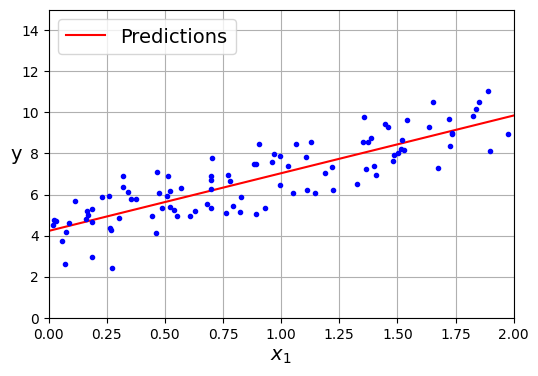

In [29]:
# plot this model's prediction
plt.figure(figsize=(6,4))
plt.plot(X_new, y_predict, "r", label="Predictions")
plt.plot(X, y, "b.")
plt.ylabel("y",rotation=0)
plt.xlabel("$x_1$")
plt.legend(loc="upper left")
plt.axis([0,2,0,15])
plt.grid()

plt.show()

In [30]:
# linear regression using Scikit-Learn 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.22747793]), array([[2.81019852]]))

In [31]:
lin_reg.predict(X_new)

array([[4.22747793],
       [9.84787498]])

The LinearRegression class is based on the scipy.linalg.lstsq() function, which stands for "least squares", which you could call directly:

In [32]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.22747793],
       [2.81019852]])



(specifically, the Moore–Penrose inverse)

In [33]:
# you can us np.linalg.pinv() to compute pseudoinverse directly:
np.linalg.pinv(X_b) @ y

array([[4.22747793],
       [2.81019852]])